# Exploratory Data Analysis with SparkR

[**Introduction to Apache Spark with R by J. A. Dianes**](https://github.com/jadianes/spark-r-notebooks)

In this notebook we will use all the SparkSQL operation we learned before in order to explore property value reltion with other variables in the [2013 American Community Survey](http://www.census.gov/programs-surveys/acs/data/summary-file.html) dataset. The whole point of R on Spark is to introduce Spark scalability into R data analysis pipelines. With this idea in mind, we have seen how [SparkR documentation](http://spark.apache.org/docs/latest/sparkr.html) introduces data types and functions that are very similar to what we are used to when using regular R. We will combine these with [ggplot2](http://ggplot2.org) in order to explore relationships between our varaibles. We will explain what we do at every step but, if you want to go deeper into `ggplot2` for exploratory data analysis, I did this [Udacity on-line course](https://www.udacity.com/course/data-analysis-with-r--ud651) in the past and I highly recommend it! 

So let's dive into it!

## Creating a SparkSQL context and loading data

In order to explore our data, we first need to load it into a SparkSQL data frame. But first we need to init a SparkSQL context. The first thing we need to do is to set up some environment variables and library paths as follows. Remember to replace the value assigned to `SPARK_HOME` with your Spark home folder.  

In [12]:
# Set Spark home and R libs
Sys.setenv(SPARK_HOME='/home/cluster/spark-1.5.0-bin-hadoop2.6')
.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths()))

Now we can load the `SparkR` library as follows.

In [3]:
library(SparkR)


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    filter, na.omit

The following objects are masked from ‘package:base’:

    intersect, rbind, sample, subset, summary, table, transform



And now we can initialise the Spark context as [in the official documentation](http://spark.apache.org/docs/latest/sparkr.html#starting-up-sparkcontext-sqlcontext). In our case we are use a standalone Spark cluster with one master and seven workers. If you are running Spark in local node, use just `master='local'`. Additionally, we require a Spark package from Databricks to read CSV files (more on this in the [previous notebook](https://github.com/jadianes/spark-r-notebooks/blob/master/notebooks/nb1-spark-sql-basics/nb1-spark-sql-basics.ipynb)). 

In [4]:
sc <- sparkR.init(master='spark://169.254.206.2:7077', sparkPackages="com.databricks:spark-csv_2.11:1.2.0")

Launching java with spark-submit command /home/cluster/spark-1.5.0-bin-hadoop2.6/bin/spark-submit  --packages com.databricks:spark-csv_2.11:1.2.0 sparkr-shell /tmp/RtmpEC6ItW/backend_port4bd622e97d86 


And finally we can start the SparkSQL context as follows.

In [5]:
sqlContext <- sparkRSQL.init(sc)

Now that we have our SparkSQL context ready, we can use it to load our CSV data into data frames. We have downloaded our [2013 American Community Survey dataset](http://www.census.gov/programs-surveys/acs/data/summary-file.html) files in [notebook 0](https://github.com/jadianes/spark-r-notebooks/tree/master/notebooks/nb0-starting-up/nb0-starting-up.ipynb), so they should be stored locally. Remember to set the right path for your data files in the first line, ours is `/nfs/data/2013-acs/ss13husa.csv`.  

In [6]:
housing_a_file_path <- file.path('', 'nfs','data','2013-acs','ss13husa.csv')
housing_b_file_path <- file.path('', 'nfs','data','2013-acs','ss13husb.csv')

Now let's read into a SparkSQL dataframe. We need to pass four parameters in addition to the `sqlContext`:  

- The file path.  
- `header='true'` since our `csv` files have a header with the column names. 
- Indicate that we want the library to infer the schema.  
- And the source type (the Databricks package in this case). 

And we have two separate files for both, housing and population data. We need to join them.

In [7]:
housing_a_df <- read.df(sqlContext, 
                        housing_a_file_path, 
                        header='true', 
                        source = "com.databricks.spark.csv", 
                        inferSchema='true')

In [8]:
housing_b_df <- read.df(sqlContext, 
                        housing_b_file_path, 
                        header='true', 
                        source = "com.databricks.spark.csv", 
                        inferSchema='true')

In [9]:
housing_df <- rbind(housing_a_df, housing_b_df)

Let's check that we have everything there by counting the files and listing a few of them.

In [10]:
nrow(housing_df)

[1] 1476313

In [11]:
head(housing_df)

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,ellip.h,wgtp71,wgtp72,wgtp73,wgtp74,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80
1,H,84,6,2600,3,1,1000000,1007549,0,1,⋯,0,0,0,0,0,0,0,0,0,0
2,H,154,6,2500,3,1,1000000,1007549,51,4,⋯,86,53,59,84,49,15,15,20,50,16
3,H,156,6,1700,3,1,1000000,1007549,449,1,⋯,161,530,601,579,341,378,387,421,621,486
4,H,160,6,2200,3,1,1000000,1007549,16,3,⋯,31,24,33,7,7,13,18,23,23,5
5,H,231,6,2400,3,1,1000000,1007549,52,1,⋯,21,18,37,49,103,38,49,51,46,47
6,H,286,6,900,3,1,1000000,1007549,76,1,⋯,128,25,68,66,80,26,66,164,88,24


## A priori and informal variable selection

From our [data dictionary](http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt) we know that the variable `VALP` represents a property value. Our goal in this notebook is to explore this variable, specially what other variables might have certain relationship with it. 

A possible way of doing this is to calculate correlation values between `VALP` and any other variable in the 230 set of them. For this we need numeric variables, and most of our dataset features are not numeric. There are other ways of doing this for categorical values but in our case we will use a more informal approach.  

First we will have a look at the dictionary and extract a list of candidates that to our knowledge could influence a propery value. Then we will use aggregations, tables, and plots, to explore relationships. The process won't be exhaustive but will show how to do this kind of analysis. Actually we won't to make this notebook so long, so we wil be fine with a reduced list of candidates. Hopefully we will get a list of variables to be used in a predictive linear model in further notebooks.

These are the 16 variables we will consider:  

- `ST`: state code, as the main geographical variable, since it someway includes region and department.  
- `ACR`: Lot size:           
  - b:  N/A (GQ/not a one-family house or mobile home)
  - 1:  House on less than one acre
  - 2:  House on one to less than ten acres 
  - 3:  House on ten or more acres
- `BLD`:
- `RMSP`: 
- `VACS`:
- `YBL`:
- A series of facilities variables:
  - `ACCESS`: Access to the Internet
           b .N/A (GQ)
           1 .Yes, with subscription to an Internet service
           2 .Yes, without a subscription to an Internet service
           3 .No Internet access at this house, apartment, or mobile home
  - `BATH`
  - `RWAT`
  - `PLM`
  - `TEL`
  - `TOIL`
- A series of cost-related variables:
  - `ELEP`:
  - `FULP`:
  - `GASP`:
  - `WATP`:

## Exploring property value by state using ggplot maps

To create a map of the United States with the states colored according to `VALP`, we can use ggplot2's `map_data` function. This functionality requires the [R package *maps*](https://cran.r-project.org/web/packages/maps/index.html), that you might need to install from the R shell.

In [45]:
# you might need to install maps by running from the R console:
# install.packages("maps")

library(ggplot2)

states_map <- map_data("state")

Our map contains a series of geometric shapes, latitudes, codes, and region names.

In [47]:
str(states_map)

'data.frame':	15537 obs. of  6 variables:
 $ long     : num  -87.5 -87.5 -87.5 -87.5 -87.6 ...
 $ lat      : num  30.4 30.4 30.4 30.3 30.3 ...
 $ group    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ order    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ region   : chr  "alabama" "alabama" "alabama" "alabama" ...
 $ subregion: chr  NA NA NA NA ...


The `region` variable there is the state name in the case of the *state* map, corresponding to the US states. We will need to match that with our housing dataset state code some way. But let's first reduce the housing dataset to what we want to represent in the map.

The dataset we want to visualise is the average property value by state. We can use SparkR as follows.

In [88]:
housing_avg_valp <- collect(
    agg(
        groupBy(housing_df, "ST"),
        AVG_VALP=avg(housing_df$VALP)
    )
)
head(housing_avg_valp)

,ST,AVG_VALP
1,31,141933.6
2,32,208622
3,33,267999
4,34,372496.1
5,35,194513.9
6,36,360343.5


Now we need to map the `ST` column to state names, so we can associate the right value to the right poligon in the `state_map` map. We have provided a csv file containing this mapping. Let's read it into a regular R data frame.

In [89]:
state_names <- read.csv("states.csv")
head(state_names)

,st,name,code
1,1,Alabama,AL
2,2,Alaska,AK
3,4,Arizona,AZ
4,5,Arkansas,AR
5,6,California,CA
6,8,Colorado,CO


So all we have to do is change the code for the name. For example, using a factor variable.

In [90]:
housing_avg_valp$region <- factor(housing_avg_valp$ST, levels=state_names$st, labels=tolower(state_names$name))

In [91]:
head(housing_avg_valp)

,ST,AVG_VALP,region
1,31,141933.6,nebraska
2,32,208622,nevada
3,33,267999,new hampshire
4,34,372496.1,new jersey
5,35,194513.9,new mexico
6,36,360343.5,new york


And then we are ready to merge the dataset with the map as follows.

In [92]:
merged_data <- merge(states_map, housing_avg_valp, by="region")
head(merged_data)

,region,long,lat,group,order,subregion,ST,AVG_VALP
1,alabama,-87.46201,30.38968,1,1,NA,1,155384
2,alabama,-87.48493,30.37249,1,2,NA,1,155384
3,alabama,-87.52503,30.37249,1,3,NA,1,155384
4,alabama,-87.53076,30.33239,1,4,NA,1,155384
5,alabama,-87.57087,30.32665,1,5,NA,1,155384
6,alabama,-87.58806,30.32665,1,6,NA,1,155384


Finally, we can use *ggplot2* with a `geom_polygon` to plot the previous merged data.

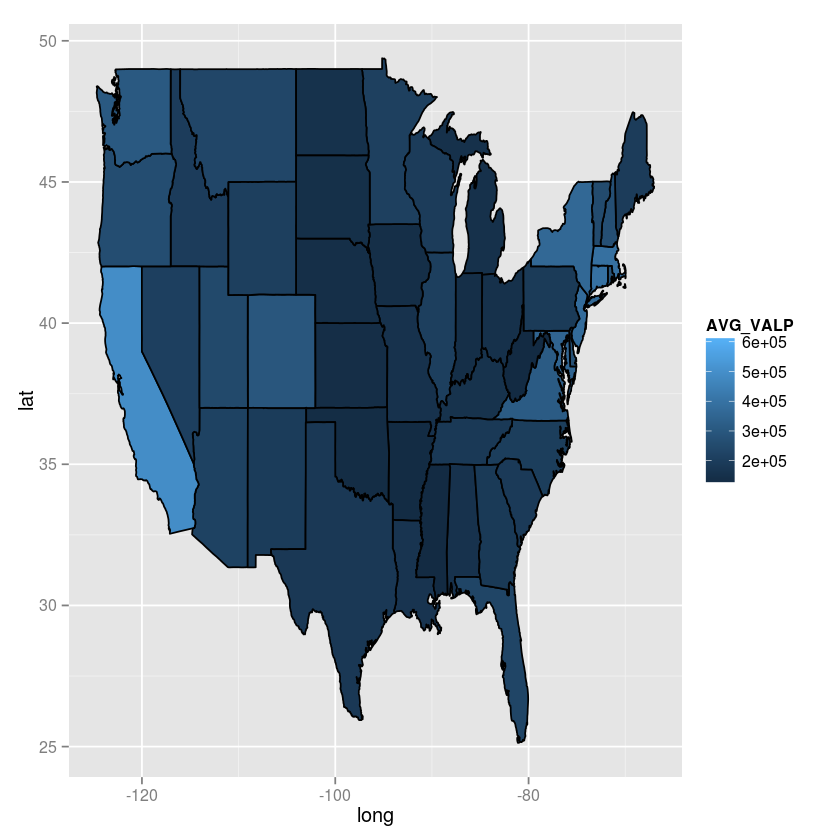

In [93]:
ggplot(merged_data, aes(x = long, y = lat, group = group, fill = AVG_VALP)) + geom_polygon(color = "black")

Hey, that property value map seem to make sense, right? States like California (West Coast), New York, or Washington DC (North East Coast) have the highest average property value, while interior states have the lowest.

So we have visualised the relationship between the state code and the property value. It seems to be at least categorical. We might try to define also a latitude-longitude relationship but it might be too weak to worth the effort. In any case I invite you to give it a try.

## Lot size and property value